To create and train a model on the MNIST dataset execute the train() in train.py.

Dataset Size: 10000
Right Predictions: 9449
Wrong Predictions: 551
Model Error: 5.51%


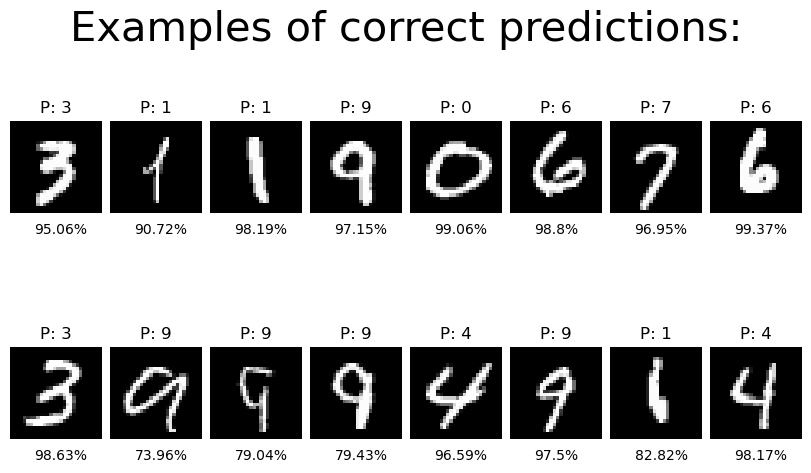

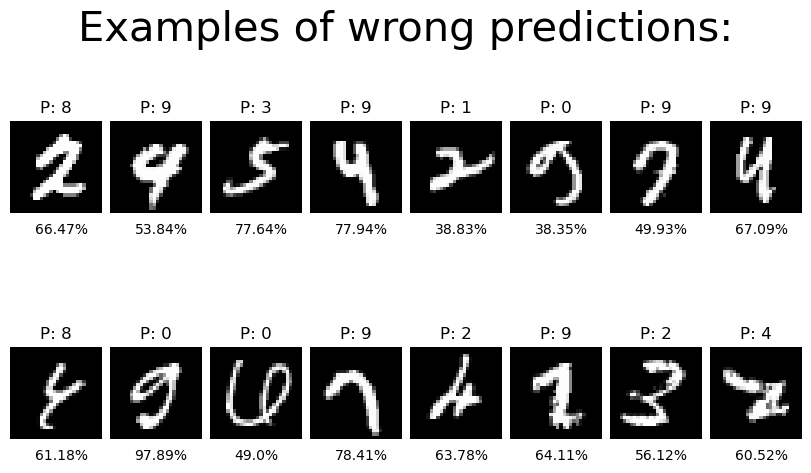

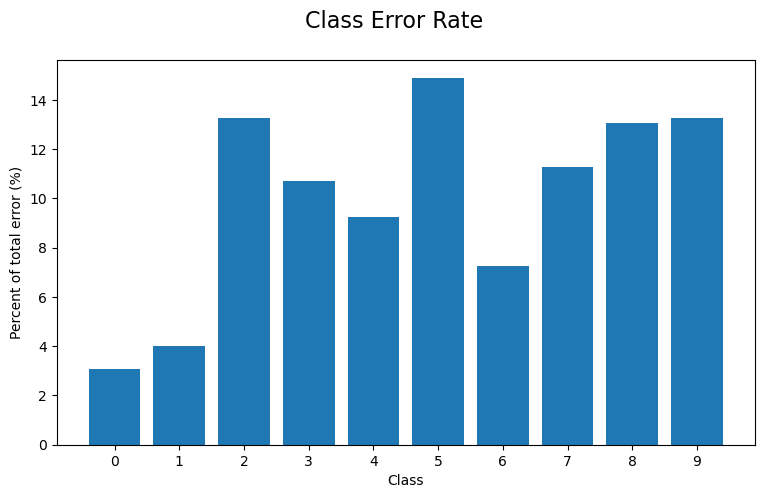

In [1]:
import torch as pt
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets

from model import Model
from one_hot_encoder import OneHotEncoder
from train import sigmoid, softmax, transform_image, propagate



# load pretrained model from file
model = Model(activations=[sigmoid, sigmoid, softmax])
model.load("models/model.pt")

classes = 10
ohe = OneHotEncoder(classes)

# prepare MNIST dataset
mnist = datasets.MNIST("data",
                       train=False,
                       download=True,
                       transform=transform_image)

# pick 10 random images
batch_size = 128
dl = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

p_idx = []
predictions = []
label = []
images = []

for img, y in dl:
    # convert label to a one hot encoding
    one_hot_y = pt.stack([ohe(l) for l in y.reshape(-1)])
    # let the model predict the class
    pred, _ = propagate(model, img, one_hot_y)
    
    # save input, prediction and label
    pred_idx = pt.argmax(pred[-1], dim=1)
    p_idx.append(pred_idx)
    predictions.append(pred[-1])
    label.append(y)
    images.append(img)

# concatenate lists
p_idx = pt.cat(p_idx)
label = pt.cat(label)
predictions = pt.cat(predictions, dim=0)
images = pt.cat(images)
images = images.reshape(len(images), 1, 28, 28)

# find wrong and correct predictions
img_wrong_idx = pt.where(p_idx != label)[0]
img_right_idx = pt.where(p_idx == label)[0]

# count wrong predictions per class
wrong_class_count = pt.empty(classes)
wrong_p = (p_idx != label)
for i in range(classes):
    sum_ = pt.sum(pt.logical_and(wrong_p, (label == i)).type(pt.int))
    wrong_class_count[i] = sum_

wrong_class_count = wrong_class_count / pt.sum(wrong_class_count) * 100.0

# print model informations
ds_size = len(mnist)
print(f"Dataset Size: {ds_size}\nRight Predictions: {len(img_right_idx)}\nWrong Predictions: {len(img_wrong_idx)}\nModel Error: {round(len(img_wrong_idx)/ds_size*100.0, 2)}%")

columns = 8
# plot correct predicted examples
plt.rcParams['figure.figsize'] = [8, 5]
fig, axs = plt.subplots(2, columns, constrained_layout=True)
for j in range(2*columns):
    ax = axs[j//columns][j%columns]
    ax.set_axis_off()
    k = img_right_idx[j].item()
    ax.imshow(images[k].squeeze(), cmap='gray')
    p = p_idx[k]
    c = predictions[k][p].item()
    ax.set_title(f"P: {p}")
    ax.text(7, 34, f"{round(c * 100, 2)}%")
fig.suptitle("Examples of correct predictions:", fontsize=30)
plt.show()

# plot wrong predicted examples
fig, axs = plt.subplots(2, columns, constrained_layout=True)
for j in range(2*columns):
    ax = axs[j//columns][j%columns]
    ax.set_axis_off()
    k = img_wrong_idx[j].item()
    ax.imshow(images[k].squeeze(), cmap='gray')
    p = p_idx[k]
    c = predictions[k][p].item()
    ax.set_title(f"P: {p}")
    ax.text(7, 34, f"{round(c * 100, 2)}%")
fig.suptitle("Examples of wrong predictions:", fontsize=30)
plt.show()

# plot class error rate
plt.rcParams['figure.figsize'] = [9, 5]
fig, ax = plt.subplots(1,1)
fig.suptitle("Class Error Rate", fontsize=16)
ar = pt.arange(classes)
ax.set_xticks(ar)
ax.set_ylabel("Percent of total error (%)")
ax.set_xlabel("Class")
ax.set_yticks(range(0,100,2))
ax.bar(ar, wrong_class_count)

plt.show()